In [48]:
import pandas as pd
import os
import ast
import numpy as np
import math
import random
from copy import deepcopy
%matplotlib inline
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format

In [49]:
# The scripts stored the outputs as dictionaries.
all_results = []
for f in os.listdir('.'):
    if '.data' in f:
        with open(f, 'r') as g:
            all_results.append(ast.literal_eval(g.read()))

In [50]:
# Standardize units of MIC
def standardize_to_uM(concentration, unit, sequence):
    concentration = concentration.replace(' ', '')
    try:
        concentration = float(concentration)
    except:
        return None
    if unit == 'uM' or unit == u'\xb5M' or unit == u'uM)':
        return concentration
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000/molWt
    elif unit == 'nmol/g' or unit == 'pmol/mg':
        #1g, at density of 1g/mL, is 1mL, so nmol/g is nmol/mL = umol/L = uM yay!
        return concentration
    else:
        # print 'Unit not recognized: ' + unit
        return None

In [51]:
# Enter an element of a result dictionary into df-ready row
def convert_result_to_rows(sequence, result):
    rows = []
    if 'bacteria' not in result:
        return rows
    for bacterium, strain in result['bacteria']:
        
        rows.append({
            'bacterium': bacterium,
            'strain': strain,
            'sequence': sequence.upper(),
            'url_source': result['url_sources'][0],
            'value': standardize_to_uM(
                result['bacteria'][(bacterium, strain)]['value'],
                result['bacteria'][(bacterium, strain)]['unit'],
                sequence
            ),
            'modifications': result['modifications'] if 'modifications' in result else [],
            'unit': 'uM'
        })
        if rows[-1]['value']:
            rows[-1]['value'] = np.log10(rows[-1]['value'])
    return rows

In [52]:
# Load all the rows into an array
rows = []
for result_set in all_results:
    for sequence in result_set:
        for row in convert_result_to_rows(sequence, result_set[sequence]):
            rows.append(row)

In [6]:
# Construct the df
df = pd.DataFrame(rows)

In [7]:
print("Dataframe length before removing bad chars:", len(df))
# Remove sequences with amino acids that aren't well-defined
def strip_sequences_with_char(df, bad_char):
    return df[~df.sequence.str.contains(bad_char)]

for bad_char in ['U', 'X', 'Z']:
    df = strip_sequences_with_char(df, bad_char)
print("Dataframe length after removing bad chars:", len(df))

('Dataframe length before removing bad chars:', 62494)
('Dataframe length after removing bad chars:', 57697)


In [8]:
# We'll want to strip off any sequences with modifications that could be hard to replicate
# Their effects are too complex for the model
def is_modified(modifications_list):
    return len(modifications_list) > 0

df['is_modified'] = df.modifications.apply(is_modified)

In [9]:
# However, C-Terminal Amidation is common enough that we make an exception
def has_non_cterminal_modification(modifications_list):
    return any(['C-Term' not in modification for modification in modifications_list])

df['has_non_cterminal_modification'] = df.modifications.apply(has_non_cterminal_modification)

df['has_cterminal_modification'] = df.is_modified & ~df.has_non_cterminal_modification

In [10]:
# Clean sequences by removing newlines and one improper sequence
df.sequence = df.sequence.str.strip()
df = df.loc[df.sequence != '/']

In [11]:
# Exclude sequences with modifications
# Exclude rows from YADAMP and CAMP for having no modification data
#     Unless that sequence is in another DB

df = df.loc[df.has_non_cterminal_modification == False]

no_modification_data_sources = ['camp3', 'yadamp']

def datasource_has_modifications(cell):
    # Everything except CAMP and YADAMP has modification data
    return not any([s in cell for s in no_modification_data_sources])

df['_datasource_has_modifications'] = df['url_source'].apply(datasource_has_modifications)

sequences_containing_modifications = set(df.loc[df._datasource_has_modifications == True, 'sequence'])
def sequence_has_modification_data(cell):
    # If the sequence is labeled modifictationless in another database it's OK
    return cell in sequences_containing_modifications

df['_sequence_has_modifications'] = df['sequence'].apply(sequence_has_modification_data)

df['modification_verified'] = df['_sequence_has_modifications'] | df['_datasource_has_modifications']

df = df.loc[df.modification_verified == True]

In [12]:
CHARACTER_DICT = set([character for sequence in df.sequence for character in sequence])
MAX_SEQUENCE_LENGTH = int(df.sequence.str.len().describe(percentiles=[0.95])['95%'])

# Each amino acid its own group
character_to_index = {
    (character): i
    for i, character in enumerate(CHARACTER_DICT)
}

# Group them together heavily
"""character_to_index = {
    ('R', 'K', 'H'): 0,
    ('D', 'E'): 1,
    ('S', 'T', 'N', 'Q', 'C'): 2,
    ('A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'P', 'G'): 3,
}

# Group them together more sparingly
character_to_index = {
    ('R'): 0,
    ('H'): 1,
    ('K'): 2,
    ('D', 'E'): 3,
    ('S', 'T', 'N', 'Q', 'C'): 4,
    ('G', 'P'): 5,
    ('A', 'V', 'I', 'L', 'M'): 6,
    ('F', 'Y', 'W'): 7,
}"""

index2character = {
    value: key
    for key, value in character_to_index.items()
}

def sequence_to_vector(sequence, cterminal_amidation):
# It looks like this truncates any sequence after max_sequence_length (which is length of 95th percentile longest peptide)
# I just add cterminal amidation as the amino acid after the last real amino acid (if the amino acid gets truncated
# then the cterminal amidation also gets cut off)
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][character_to_index[character]] = 1
    if len(sequence)<MAX_SEQUENCE_LENGTH:
        default[len(sequence)][-1]=cterminal_amidation
    return default

def old_sequence_to_vector(sequence, cterminal_amidation):
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][character_to_index[character]] = 1
        default[i][-1] = cterminal_amidation
    return default

def find_character(character2index, character):
    for key in character2index:
        if character in key:
            return character2index[key]
    return -2

def row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_modification']
    return sequence_to_vector(sequence,cterminal_amidation)

def old_row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_modification']
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])

    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][find_character(character_to_index, character)] = 1
        default[i][-1] = cterminal_amidation

    return default

def vector_to_amp(vector):
    sequence = ''
    has_cterm = False
    for v in vector:
        nonzeros = np.argwhere(v[:len(character_to_index)])
        if len(nonzeros) > 1:
            print("?????")
        elif len(nonzeros) == 0:
            sequence += '_'
        else:
            sequence += index2character[np.argwhere(v)[0][0]]  # First one
        if v[-1]>0:
            has_cterm=True
    return {
        'sequence': sequence,
        'cterminal_amidation': has_cterm
    }

def bacterium_to_sample_weight(bacterium, intended_bacterium='E. coli'):
    if intended_bacterium in bacterium:
        return 1
    else:
        return 0.5

In [13]:
def containing_bacterium(bacterium, df):
    return df.loc[df.bacterium.str.contains(bacterium)]

def average_over_databases(bacterium_df):
    return bacterium_df.groupby('sequence')['value'].mean().dropna()

staph = containing_bacterium('S. aureus', df)
staph = average_over_databases(staph)

ecoli = df.loc[df.bacterium.str.contains('E. coli')].groupby('sequence')['value'].mean().dropna()
pseudomonas = df.loc[df.bacterium.str.contains('P. aeruginosa')].groupby('sequence')['value'].mean().dropna()
streptococcus = df.loc[df.bacterium.str.contains('S. mutans')].groupby('sequence')['value'].mean().dropna()
bacillus = df.loc[df.bacterium.str.contains('B. subtilis')].groupby('sequence')['value'].mean().dropna()

In [14]:
# Show the correlation between bacteria
# Note that Gram-Positivity seems to have a strong effect on correlation
# E. coli and pseudomonas are highly correlated
# While neither is correlated with streptococcus, staph or bacillus
# Meanwhile, staph and streptococcus are strongly correlated as expected
# As are bacillus and streptococcus
# The lack of correlation between bacillus and staph is a mystery to me
many_bacteria = pd.concat([ecoli, pseudomonas, streptococcus, staph, bacillus], axis=1).reset_index()
many_bacteria.columns = ['index', 'ecoli', 'pseudomonas', 'streptococcus', 'staph', 'bacillus']
many_bacteria.corr()

,ecoli,pseudomonas,streptococcus,staph,bacillus
ecoli,1.00,0.78,0.71,0.67,0.69
pseudomonas,0.78,1.00,0.52,0.65,0.60
streptococcus,0.71,0.52,1.00,0.83,0.82
staph,0.67,0.65,0.83,1.00,0.67
bacillus,0.69,0.60,0.82,0.67,1.00


In [15]:
# Since ecoli data and pseudomonas data are highly correlated, we will use some pseudomonas data in the model
# (With a lower sample weight)
ecoli_pseudomonas = many_bacteria.dropna(subset=('ecoli', 'pseudomonas'))
x = np.array(ecoli_pseudomonas['pseudomonas']).reshape(-1, 1)
y = np.array(ecoli_pseudomonas['ecoli']).reshape(-1, 1)
pseudomonas_to_ecoli_model = LinearRegression().fit(x, y)

/Users/jacobwitten/anaconda/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [16]:
def get_bacterium_df(bacterium, df):
    bdf = df.loc[(df.bacterium.str.contains(bacterium))].groupby(['sequence', 'bacterium'])
    return bdf.mean().reset_index().dropna()

In [17]:
def strip_bad_amino_acids(df, bad_amino_acids=('U', 'X', 'Z')):
    for b in bad_amino_acids:
        df = df.loc[~df.sequence.str.contains(b)]
    return df

In [18]:
ecoli_df = get_bacterium_df('E. coli', df)
ecoli_df = strip_bad_amino_acids(ecoli_df)

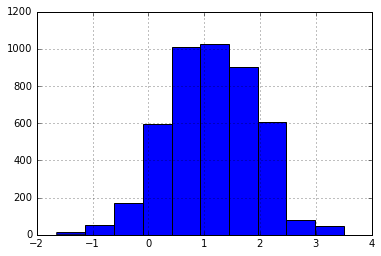

In [19]:
# MIC on E. coli is normally distributed-ish
ecoli_df.value.hist()

In [20]:
# Generate the input vectors for our model
# Each vector is two dimensional
# The first dimension represents the number of characters in the sequence (46 characters)
# Each character is a vector of length equal to the number of groupings of amino acids
# This grouping can be 1-1 (each amino acid gets its own group), or coarser
SHUFFLE_SEQUENCE = False
cterminal_amidation = np.array(ecoli_df.has_cterminal_modification)

vectors = []
for row in ecoli_df.iterrows():
    vectors.append(row_to_vector(row[1], shuffle_sequence=SHUFFLE_SEQUENCE))

vectors = np.array(vectors)

labels = np.array(ecoli_df.value)
sample_weights = np.full(len(labels), 1)

In [21]:
def generate_random_sequence(alphabet, length_of_sequence_min=25, length_of_sequence_max=40):
        sequence = ''
        for _ in range(random.choice(range(length_of_sequence_min, length_of_sequence_max))):
            sequence += random.choice(list(alphabet))
        has_cterminal_modification = random.choice([0, 1])

        return {
            'sequence': sequence,
            'has_cterminal_modification': has_cterminal_modification
        }

def add_random_negative_examples(vectors, labels, sample_weights, ratio, max_mic = None):
    if not max_mic:
        max_mic = max(labels)
    # We will add randomly chosen sequences as negative examples
    # We will double the length of our training set

    len_vectors = ratio * len(vectors)
    negative_rows = []
    for i in range(len_vectors):
        negative_rows.append(row_to_vector(generate_random_sequence(list(CHARACTER_DICT))))
    negative_vectors = np.array(negative_rows)
    vectors = np.concatenate((vectors, negative_vectors))
    negative_labels = np.full(len_vectors, max_mic)
    labels = np.concatenate((labels, negative_labels))
    # Weight all samples equally
    sample_weights = np.concatenate((sample_weights, np.full(len_vectors, 1)))
    return vectors, labels, sample_weights

In [22]:
MAX_MIC = 4
vectors, labels, sample_weights = add_random_negative_examples(vectors, labels, sample_weights, ratio=4, max_mic=MAX_MIC)

In [23]:
print("Vector shape after adding negative examples")
print(vectors.shape)

Vector shape after adding negative examples
(22540, 46, 21)


In [24]:
# Create simulated ecoli data from pseudomonas data
bacteria_name = 'P. aeruginosa'
pa_df = df.loc[(df.bacterium.str.contains(bacteria_name))].groupby(['sequence', 'bacterium'])
pa_df = pa_df.mean().reset_index().dropna()

pa_cterminal_amidation = np.array(pa_df.has_cterminal_modification)

pa_vectors = []
for row in pa_df.iterrows():
    pa_vectors.append(row_to_vector(row[1], shuffle_sequence=SHUFFLE_SEQUENCE))

pa_vectors = np.array(pa_vectors)

pa_labels = np.array(pa_df.value.apply(pseudomonas_to_ecoli_model.predict))  # Interpolate using the linear model
pa_sample_weights = np.array([0.5] * len(pa_labels))

In [25]:
average = np.mean(labels)
squared_errors = sum([(label - average) ** 2 for label in labels])
baseline_error = squared_errors/len(labels)
print("Baseline error:")
print(baseline_error)
measured_labels = [l for l in labels if l < MAX_MIC]
average = np.mean(measured_labels)
squared_errors = sum([(label - average) ** 2 for label in measured_labels])
baseline_error = squared_errors/len(measured_labels)
print("Baseline error on measured examples only")
print(baseline_error)

Baseline error:
1.4327302826406154
Baseline error on measured examples only
0.60182344038256


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
linear_estimator = LinearRegression()
#cross_val_score(linear_estimator, vectors.reshape(vectors.shape[0], -1)[:10], labels[:10])
i = 200
#cross_val_score(linear_estimator, np.full(i, 1).reshape(-1, 1), random_labels, scoring='neg_mean_squared_error')
#linear_estimator.fit(vectors.reshape(vectors.shape[0], -1)[:95], labels[:95])
linear_estimator.fit(np.full(shape=(len(labels)), fill_value=1).reshape(-1, 1), labels)
#cross_val_score(linear_estimator, vectors.reshape(vectors.shape[0], -1), labels, scoring='neg_mean_squared_error')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
import keras
from keras.layers import Dense, Dropout, LSTM, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

/Users/jacobwitten/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
def generate_train_test_splits(
        vectors, labels,
        extra_training_vectors=[], extra_training_labels=[], extra_sample_weights=[],
        cutoff=0.85
):
    cutoff = int(cutoff * len(labels))
    idx = range(len(vectors))
    random.shuffle(idx)
    reordered_vectors = vectors[idx]
    reordered_labels = labels[idx]
    reordered_sample_weights = sample_weights[idx]
    if len(extra_training_vectors) > 0:
        train_x = np.concatenate((reordered_vectors[:cutoff], extra_training_vectors))
        train_y = np.concatenate((reordered_labels[:cutoff], extra_training_labels))
        train_sample_weights = np.concatenate((reordered_sample_weights[:cutoff], pa_sample_weights))
    else:
        train_x = reordered_vectors[:cutoff]
        train_y = reordered_labels[:cutoff]
        train_sample_weights = reordered_sample_weights[:cutoff]
    test_x = reordered_vectors[cutoff:]
    test_y = reordered_labels[cutoff:]
    return train_x, train_y, test_x, test_y, train_sample_weights

In [29]:
# Convolutional NN
def conv_model():
    model = keras.models.Sequential()
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [76]:
convmodel = conv_model()
train_x, train_y, test_x, test_y, _ = generate_train_test_splits(vectors, labels, pa_vectors, pa_labels, pa_sample_weights)
convmodel.fit(train_x, train_y, batch_size=40, epochs=100)

Epoch 1/100
21652/21652 [==============================] - 7s 339us/step - loss: 0.7724
Epoch 2/100
21652/21652 [==============================] - 7s 319us/step - loss: 0.3829
Epoch 3/100
21652/21652 [==============================] - 8s 347us/step - loss: 0.2831
Epoch 4/100
21652/21652 [==============================] - 8s 352us/step - loss: 0.2244
Epoch 5/100
21652/21652 [==============================] - 6s 300us/step - loss: 0.1927
Epoch 6/100
21652/21652 [==============================] - 7s 304us/step - loss: 0.1575
Epoch 7/100
21652/21652 [==============================] - 7s 323us/step - loss: 0.1372
Epoch 8/100
21652/21652 [==============================] - 8s 351us/step - loss: 0.1181
Epoch 9/100
21652/21652 [==============================] - 8s 369us/step - loss: 0.1130
Epoch 10/100
21652/21652 [==============================] - 8s 358us/step - loss: 0.1004
Epoch 11/100
21652/21652 [==============================] - 7s 340us/step - loss: 0.1034
Epoch 12/100
21652/21652 [====

In [77]:
print("CNN test error, MSE of log MIC")
print(convmodel.evaluate(test_x, test_y))

CNN test error, MSE of log MIC
3381/3381 [==============================] - 1s 167us/step
0.11308013951238956


In [110]:
# THIS IS THE OLD ONE
print("CNN test error, MSE of log MIC")
print(convmodel.evaluate(test_x, test_y))

CNN test error, MSE of log MIC
2705/2705 [==============================] - 1s 193us/step
0.10254753295077414


In [78]:
print("CNN test error on measured examples only")
print(np.mean(
    [(actual - predicted) ** 2 
     for actual, predicted in zip(test_y, convmodel.predict(test_x)) if actual < MAX_MIC
    ]
))

CNN test error on measured examples only
0.55005944


In [111]:
# THIS IS THE OLD ONE
print("CNN test error on measured examples only")
print(np.mean(
    [(actual - predicted) ** 2 
     for actual, predicted in zip(test_y, convmodel.predict(test_x)) if actual < MAX_MIC
    ]
))

CNN test error on measured examples only
0.38956055


In [304]:
print("CNN test error on measured examples only (RANDOM SHUFFLED SEQUENCE)")
print(np.mean(
    [(actual - predicted) ** 2 
     for actual, predicted in zip(test_y, convmodel.predict(test_x)) if actual < MAX_MIC
    ]
))

CNN test error on measured examples only (RANDOM SHUFFLED SEQUENCE)
0.29721802


In [33]:
scales={'Eisenberg':{'A':  0.25, 'R': -1.80, 'N': -0.64,'D': -0.72, 'C':  0.04, 'Q': -0.69,'E': -0.62, 'G':  0.16, 'H': -0.40,'I':  0.73, 'L':  0.53, 'K': -1.10,'M':  0.26, 'F':  0.61, 'P': -0.07,'S': -0.26, 'T': -0.18, 'W':  0.37,'Y':  0.02, 'V':  0.54},
'Normalized_consensus':{'A':0.62,'C':0.29,'D':-0.9,'E':-0.74,'F':1.19,'G':0.48,'H':-0.4,'I':1.38,'K':-1.5,'L':1.06,'M':0.64,'N':-0.78,'P':0.12,'Q':-0.85,'R':-2.53,'S':-0.18,'T':-.05,'V':1.08,'W':0.81,'Y':0.26}}

def hydrophobic_moment(sequence,scale='Normalized_consensus',angle=0,is_in_degrees=True,normalize=True):
    # Angle should be 100 for alpha helix, 180 for beta sheet
    hscale=scales[scale]
    sin_sum = 0
    cos_sum = 0
    moment=0
    for i in range(len(sequence)):
        hp=hscale[sequence[i]]
        angle_in_radians=i*angle
        if is_in_degrees:
            angle_in_radians = (i*angle)*math.pi/180.0
        sin_sum += hp*math.sin(angle_in_radians)
        cos_sum += hp*math.cos(angle_in_radians)
    moment = math.sqrt(sin_sum**2+cos_sum**2)
    if normalize:
        moment = moment/len(sequence)
    return moment

In [34]:
ecoli_amps_sequence = ecoli_df['sequence']
amp_hydrophobic_moments = ecoli_amps_sequence.apply(hydrophobic_moment)

shuffled_ecoli_amps = ecoli_amps_sequence.apply(lambda x: ''.join(random.sample(x, len(x))))
# Randomly shuffled AMP sequences
shuffled_amp_hydrophobic_moments = shuffled_ecoli_amps.apply(hydrophobic_moment)

In [38]:
def evaluate_peptide(peptide, model):
    sequence = peptide['sequence']
    cterm = peptide['has_cterminal_modification']
    return model.predict(row_to_vector(
        {'sequence': sequence, 'has_cterminal_modification': int(cterm)}
    ).reshape(-1, MAX_SEQUENCE_LENGTH, len(character_to_index) + 1))


def find_nearby_sequences(sequence, old_sequences=None, character_dict=CHARACTER_DICT):
    new_sequences = set()
    if old_sequences == None:
        old_sequences = set()

    for i in range(len(sequence)):
        for c1 in character_dict:
            for j in range(i + 1, len(sequence)):
                for c2 in character_dict:
                    new_sequence = sequence[:i] + c1 + sequence[i+1:j] + c2 + sequence[j+1:]
                    for cterm in (True, False):
                        ns_dict = {'sequence': new_sequence, 'has_cterminal_modification': cterm}
                        new_sequences.add(frozenset(ns_dict.items()))
    return old_sequences | new_sequences

def evaluate_peptides(peptides, model):
    return model.predict(
        np.array(
            [row_to_vector(dict(p)) for p in peptides]
        ).reshape(
            -1, MAX_SEQUENCE_LENGTH, len(character_to_index) + 1
        )
    )

In [39]:
def nearby_peptide_vectors(peptide_vector):
    nearby_vectors = []
    for i in range(len(peptide_vector)):
#         print peptide_vector[i]
        if np.sum(peptide_vector[i][:len(peptide_vector[i])-1])>0.5:
            for j in range(len(peptide_vector[i]) - 1):  # - 1 because of amidation
                v = np.zeros(len(peptide_vector[i]))
                v[-1] = peptide_vector[0][-1]
                v[j] = 1
                new_vector = np.concatenate([
                    peptide_vector[:i],
                    v.reshape(-1, len(peptide_vector[i])),
                    peptide_vector[i+1:]
                ])
                if is_acceptable(vector_to_amp(new_vector)['sequence']):
                    nearby_vectors.append(new_vector)
                else:
                    print 'unacceptable! '+repr(vector_to_amp(new_vector)['sequence'])
#                     cterm_flipped = deepcopy(new_vector)
#                     reverse_cterm = (new_vector[0][-1] + 1) % 2
#                     for c in cterm_flipped:
#                         c[-1] = reverse_cterm
#                     nearby_vectors.append(cterm_flipped)
#         else:
#             print 'Nope!'+repr(i)
    return nearby_vectors

In [36]:
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist

In [37]:
def is_acceptable(sequence_with_padding):
    at_underscore=False
    for char in sequence_with_padding:
        if char == '_':
            at_underscore=True
        elif at_underscore:
            return False
    return True

In [70]:
def generate_sequence(cdict=CHARACTER_DICT,min_seq_length=10):
    s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length)
    v = row_to_vector(s)
    last=''
    for i in range(100):
        vs = nearby_peptide_vectors(v)
        ps = convmodel.predict(np.array(vs))
        best_i = min(range(len(ps)), key=lambda x: ps[x])
        v = vs[best_i]
        if vector_to_amp(v)['sequence']==last:
            break
        last=vector_to_amp(v)['sequence']
    return vector_to_amp(v), ps[best_i][0]

def generate_sequence_from_exp_sequences(sequence_pool,max_generated_length=25):
    sequence=''
    for ind in range(max_generated_length):
#         print len(sequence_pool)
        which_ind = random.randint(0,len(sequence_pool)-1)
#         print 'which ind: '+repr(which_ind)
        which = sequence_pool[which_ind]
#         print which
        if len(sequence)<len(which):
#             print which[len(sequence)]
            sequence=sequence+which[len(sequence)]
        else:
            break
    has_cterminal_modification = random.choice([0, 1])>0.5
#     print len(sequence)
    return {
        'sequence': sequence,
        'has_cterminal_modification': has_cterminal_modification
    }

def generate_move(old_vector,min_length=10,max_length=25):
    vector=deepcopy(old_vector)
    asc=random.random()
    peptide_length=0
    for i in range(len(vector)):
        if np.sum(vector[i][:len(vector[i])-1])>0.5:
            peptide_length=i+1
    if asc<0.025 and peptide_length>=min_length:
#         Remove from the front 2.5% of the time
        for i in range(len(vector)-1):
            vector[i]=[k for k in vector[i+1]]
        vector[len(vector)-1]=[0 for k in vector[0]]
    elif asc < 0.05 and peptide_length>=min_length:
#         Remove from the back 2.5% of the time
        if peptide_length==len(vector):
            vector[len(vector)-1]=[0]*len(vector[0])
        else:
            vector[peptide_length-1]=[k for k in vector[peptide_length]]
            vector[peptide_length]=[0]*len(vector[0])
    elif asc < .075 and peptide_length<max_length:
#         Add to the front 2.5% of the time
        which = random.randint(0,len(vector[0])-2)
        blah=0
        while which == character_to_index['C'] and blah<10:
            which = random.randint(0,len(vector[0])-2)
            blah += 1
        for i in range(1,len(vector)):
            vector[-i]=[k for k in vector[-i-1]]
        vector[0]=[0 for k in vector[1]]
        vector[0][which]=1
    elif asc < .1 and peptide_length<max_length:
#         Add to the back 2.5% of the time
        which = random.randint(0,len(vector[0])-2)
        blah=0
        while which == character_to_index['C'] and blah<10:
            which = random.randint(0,len(vector[0])-2)
            blah += 1
        vector[peptide_length][which]=1
        if peptide_length<(len(vector)-1):
            vector[peptide_length+1][len(vector[0])-1]=vector[peptide_length][len(vector[0])-1]
        vector[peptide_length][-1]=0
#     elif asc > 0.995 and peptide_length<len(vector):
#     Toggle amidation 0.5% of the time
#         vector[peptide_length][-1]=(vector[peptide_length][-1]+1)%2
    else:
#         Swap something in the middle
        which_index=random.randint(0,peptide_length-1)
        which_residue=random.randint(0,len(vector[0])-2)
        blah=0
        while which_residue == character_to_index['C'] and blah<10:
            which_residue = random.randint(0,len(vector[0])-2)
            blah += 1
        try:
#             print which_index
            vector[which_index]=[0 for k in vector[0]]
            vector[which_index][which_residue]=1
        except:
            print 'Trying to change index '+repr(which_index)+' but array is only of length '+repr(len(vector))
    if not is_acceptable(vector_to_amp(vector)['sequence']):
        print 'asc is: '+repr(asc)+' and sequence is '+repr(vector_to_amp(vector)['sequence'])
        print 'which_residue: '+repr(which_residue)+', out of '+repr(len(vector[0])-1)
        return old_vector
    peptide_length=0
    for i in range(len(vector)):
        if np.sum(vector[i][:len(vector[i])-1])>0.5:
            peptide_length=i+1
    vector[peptide_length][-1]=1
    return vector

def accept_move(mic_old,mic_new,temp):
    if mic_new<mic_old:
        return True
    return random.random()<np.exp((mic_old-mic_new)/temp)

def generate_sequence_by_simulated_annealing(cdict=CHARACTER_DICT,min_seq_length=10,nsteps=100000,t0=1/np.log(2),tf=0.00001/np.log(2),all_seq=None):
    if all_seq==None:
        s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length)
    else:
        s = generate_sequence_from_exp_sequences(all_seq)
    v = row_to_vector(s)
    print 'Starting sequence: '+repr(s)
    last=''
    #So a transition that increases MIC by 1 will have acceptance probability of 0.5 in default
    temp = t0
    scale=np.power(tf/t0,1./nsteps)
    for i in range(nsteps):
        move = generate_move(v)
        old_and_new = convmodel.predict(np.array([v,move]))
        if accept_move(old_and_new[0][0],old_and_new[1][0],temp):
            v = move
        temp=temp*scale
#     print vector_to_amp(v)
#     print convmodel.predict(np.array([v]))[0][0]
    return vector_to_amp(v), convmodel.predict(np.array([v]))[0][0]

def generate_random_sequences(cdict=CHARACTER_DICT,min_seq_length=10):
    s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length)
    v = row_to_vector(s)
    last=''
    p=convmodel.predict(np.array([v]))
    return vector_to_amp(v), p[0][0]

In [73]:
nseqs=10
sequences=['']*nseqs
pred_log_mics=[0]*nseqs
for i in range(nseqs):
    seq,plm=generate_sequence_by_simulated_annealing(all_seq=all_sequences,nsteps=100000)
    sequences[i]=seq
    pred_log_mics[i]=plm
print sequences
print pred_log_mics
print np.mean(pred_log_mics)
print np.std(pred_log_mics)

Starting sequence: {'has_cterminal_modification': False, 'sequence': u'GIPGTIRGASK'}
Starting sequence: {'has_cterminal_modification': False, 'sequence': u'SKWSTYMGG'}
Starting sequence: {'has_cterminal_modification': False, 'sequence': u'IRNPRSAKQGKKW'}
Starting sequence: {'has_cterminal_modification': True, 'sequence': u'RRRKVIRK'}
Starting sequence: {'has_cterminal_modification': True, 'sequence': u'ILSKTRGVLFIKA'}
Starting sequence: {'has_cterminal_modification': True, 'sequence': u'DVTYVVLGHARTI'}
Starting sequence: {'has_cterminal_modification': True, 'sequence': u'QHERHWKKRFNSILFGT'}
Starting sequence: {'has_cterminal_modification': True, 'sequence': u'AGFWLFAVRP'}
Starting sequence: {'has_cterminal_modification': True, 'sequence': u'AKIRVWRRGLKKG'}
Starting sequence: {'has_cterminal_modification': True, 'sequence': u'FLHTLFVWAWPKRAK'}
[{'cterminal_amidation': True, 'sequence': u'KRRRRKQRKRRVI_________________________________'}, {'cterminal_amidation': True, 'sequence': u'PIRRRG

In [74]:
# best_indices=np.argpartition(pred_log_mics,4)[:4]
# print best_indices
# for index in best_indices:
for index in range(len(sequences)):
    seq=sequences[index]['sequence'][:sequences[index]['sequence'].find('_')]
    print seq
    print pred_log_mics[index]
    show_best_n_alignments(seq,all_sequences,1)
    print hmoment_analysis(seq)
    print '\n'

KRRRRKQRKRRVI
-0.21869785
KRRRRKQRKRRVI---------------------
 ||||||||||||
-RRRRRRRRRRGIGKFLHSAKKFGKAFVGEIMNS
  Score=57

([0.17076746470377288, 0.1919030026788329, 0.036923076923076885], [13.999999999999966, 21.00000000000003, 7.899999999999988])


PIRRRGYRRVYTRYI
-0.43427992
------PIRRRG----YRRVYTRYI
       ||||||||||||
RWCVYAYVRRRGVLVRYRRCW----
  Score=46

([0.26265339610088617, 0.3934377550953743, 0.4126666666666667], [29.800000000000153, 52.70000000000048, 64.30000000000062])


SRIHRKPHYFPEYTQHIYRKRF
-1.3272889
SRIHRKPHYFPEYTQHIYRKRF----
                 |||||
---------------RLYRRRFVVGR
  Score=35

([0.3898483016594645, 0.08742896536226918, 0.010000000000000009], [88.29999999999926, 8.099999999999987, 2.600000000000001])


PKWKKWRITRRVI
-0.20490187
PKWKKW-RITRRVI---
  |||||||||||
-WWKRWKRI-RRIFMMV
  Score=49

([0.4039710386899987, 0.46540474417056504, 0.1569230769230769], [55.60000000000052, 67.20000000000046, 26.500000000000107])


EGFSVKHRTKGYTKRI
-0.48284125
-EGFSVKHRTKGYTKRI--

In [79]:
good_seqs=['GRKTSRYRIRLIYRLRIRM','GRHLIWKLIKTYRPHPRL','MDPKQQLFGRKATPTHRVIIRYT','KLTKAGRLLSIRLKNQGRVV','WKHGKIGKWIKRYT']
good_seqs.append('WKHGKIGKWIKRYT')
good_seqs.append('KIKKWRRPLYSGRKKYQ')
good_seqs.append('SRIHRKPHYFPEYTQHIYRKRF')
good_seqs.append('RFKRLYRITRRVI')
good_seqs.append('FKWPRYHKYNHRAVQPIRKR')
good_seqs.append('TEKWLHRLSHDPVDTPIRKT')
good_seqs.append('FRMMRIRRRTGYRVI')
# Filters: predicted by https://www.dveltri.com/ascan/v2/ascan.html to be AMP
# Predicted by a second model (not the one it was trained on) to have good AMP activity
# High hydrophobic moment (compared to shuffled versions of itself)
# Predicted by pepcalc to have good water solubility
# Length < 25
# Substitute serine (S) for cysteine because disulfide bonds are confusing
# (Later runs just refuse to incorporate cysteine)
# Sequence alignment shows it's not just copying something
mics=convmodel.predict(np.array([sequence_to_vector(seq,True) for seq in good_seqs]))
print mics

[[0.717005  ]
 [1.3017523 ]
 [1.2388521 ]
 [0.66926587]
 [1.0179906 ]
 [1.0179906 ]
 [0.49489325]
 [1.0871339 ]
 [0.6007128 ]
 [0.7997312 ]
 [1.4129379 ]
 [0.85508037]]


In [ ]:
# For FASTA search
>m1
GRKTSRYRIRLIYRLRIRM
>m2
GRHLIWKLIKTYRPHPRL
>m3
MDPKQQLFGRKATPTHRVIIRYT
>m4
KLTKAGRLLSIRLKNQGRVV
>m5
WKHGKIGKWIKRYT
>m6
WKHGKIGKWIKRYT
>m7
KIKKWRRPLYSGRKKYQ
>m8
SRIHRKPHYFPEYTQHIYRKRF
>m9
RFKRLYRITRRVI
>m10
FKWPRYHKYNHRAVQPIRKR
>m11
TEKWLHRLSHDPVDTPIRKT
>m12
FRMMRIRRRTGYRVI

In [40]:
def show_best_n_alignments(test_sequence,sequence_db,nalign,score_matrix=matlist.pam30,gap_open_penalty=-9,gap_extension_penalty=-1):
#     blosum62 is another option. Identity matrix is another. I think they're about the same.
    alignment_scores=[0]*len(sequence_db)
    for i in range(len(all_sequences)):
        sequence=all_sequences[i]
        alignment_scores[i]=pairwise2.align.localds(test_sequence,sequence,score_matrix,gap_open_penalty,gap_extension_penalty,score_only=True)
    argm = np.argmax(alignment_scores)
#     alignments=pairwise2.align.localds(test_sequence,all_sequences[argm],score_matrix,gap_open_penalty,gap_extension_penalty)
    indices=np.argpartition(alignment_scores,-1*nalign)[(-1*nalign):]
    for index in indices:
        alignments=pairwise2.align.localds(test_sequence,all_sequences[index],score_matrix,gap_open_penalty,gap_extension_penalty)
        print(pairwise2.format_alignment(*alignments[0]))

In [57]:
all_sequences=[sequence for sequence in ecoli_df.sequence]
show_best_n_alignments('GRRWKLMKHVTETPNPR',all_sequences,3)

GRRWKLMKHVTETPNPR
||||||||||
GKWWSLLKHILK-----
  Score=39

GRRWKLMKHVTETPNPR-----
   |||||||
--KWKLKKHIGIGKHFLSAKKF
  Score=43

GRRW-KLMKHVTETPNPR
 |||||||
RRRWWKLMM---------
  Score=45



In [41]:
def hmoment_analysis(test_sequence,angles=[100,140,180]):
    hmoments=[0]*len(angles)
    percentiles=[0]*len(angles)
    for k in range(len(angles)):
        test_angle=angles[k]
        hmoments[k] = hydrophobic_moment(test_sequence,angle=test_angle)
        other_h_moments=[0]*1000
        shuffled=range(len(test_sequence))
        perGreater=0
        for i in range(1000):
            np.random.shuffle(shuffled)
            shuffled_seq=[test_sequence[j] for j in shuffled]
            other_h_moments[i]=hydrophobic_moment(shuffled_seq,angle=test_angle)
            if other_h_moments[i]<hydrophobic_moment(test_sequence,angle=test_angle):
                perGreater+=.1
        percentiles[k]=perGreater
    return hmoments,percentiles

In [97]:
print hmoment_analysis(u'YLFGLRVGKCWERNKALIAGTVLRISFH')

([0.28744000139810794, 0.23115044867895798, 0.19357142857142856], [77.79999999999986, 63.000000000000625, 56.20000000000053])


In [276]:
v[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1.])